 Template file loaded successfully


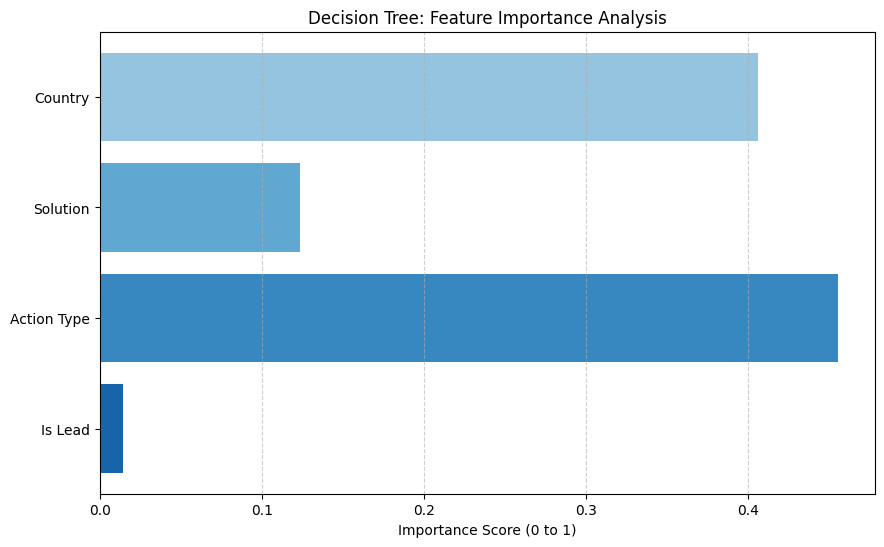


 CUSTOMER JOURNEY SYSTEM: US | MRS

 FEATURE IMPORTANCE (Model Weights):
   - Action Type    : 45.6% 
   - Country        : 40.6% 
   - Solution       : 12.4% 
   - Is Lead        : 1.5% 

 TOP 5 PATHS :
   [572 times]: Inbound Call
   [420 times]: Inbound Call -> Inbound Call
   [304 times]: Email
   [182 times]: Email -> Email
   [114 times]: Inbound Call -> Inbound Call -> Inbound Call

 RECOMMENDATIONS:
• Top 4 by Country:            ['Email', 'Inbound Call', 'Outbound Call', 'Meeting']
• Top 4 by Solution:           ['Email', 'Inbound Call', 'Call', 'Meeting']
• Top 4 by Country & Solution: ['Email', 'Inbound Call', 'Meeting', 'Follow Up']

 RECALCULATED NEXT STEPS :
   - Review          | Prob: 75.7%
   - Follow Up       | Prob: 72.2%
   - Meeting         | Prob: 63.5%
   - On-Site         | Prob: 56.8%

 BEST SHORTER JOURNEY TO WIN:
   Meeting

------------------------------
 AVAILABLE DATA SUMMARY:
------------------------------
  THE COUNTRIES LIST:  ['US', 'FR', 'MARTINIQUE'

In [1]:
# nemer_339775   Omira_275820   Riham_326730  Wissam_287747
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# 1- تجهيز البيانات من ملف القالب (xltx)
try:
    # استخدام engine='openpyxl'  لقراءة ملفات xltx  
    df = pd.read_excel('data_all.xltx', engine='openpyxl')
    print(" Template file loaded successfully")
except Exception as e:
    print(f" Failed to load file: {e}")
    

# تنظيف المسافات وتوحيد حالة الأحرف 
df['Country'] = df['Country'].astype(str).str.strip().str.upper()
df['solution'] = df['solution'].astype(str).str.strip().str.upper()

# تنظيف البيانات ومعالجة التواريخ والقيم المفقودة
df['activity_date'] = pd.to_datetime(df['activity_date'])
df['opportunity_stage'] = df['opportunity_stage'].fillna('no_opp')
df['is_lead'] = df['is_lead'].fillna(0)
df = df.dropna(subset=['types'])

# تحديد الهدف  WON = 1, Others = 0
df['target'] = df['opportunity_stage'].apply(lambda x: 1 if 'WON' in str(x).upper() else 0)

# =====================================
# 2- تجميع المسارات 
df = df.sort_values(['account_id', 'activity_date'])

# بناء المسارات لكل عميل
paths_df = df.groupby(['account_id', 'Country', 'solution']).agg({
    'types': lambda x: ' -> '.join(x),
    'target': 'max'
}).reset_index()

# حساب أعلى 5 مسارات تكراراً 
top_paths_summary = paths_df.groupby(['Country', 'solution', 'types']).size().reset_index(name='frequency')
top_paths_summary = top_paths_summary.sort_values(['Country', 'solution', 'frequency'], ascending=[True, True, False])

# =====================================
# 3- تدريب شجرة القرار 
le_country, le_solution, le_types = LabelEncoder(), LabelEncoder(), LabelEncoder()

df['c_enc'] = le_country.fit_transform(df['Country'])
df['s_enc'] = le_solution.fit_transform(df['solution'])
df['t_enc'] = le_types.fit_transform(df['types'])

features = ['c_enc', 's_enc', 't_enc', 'is_lead']
X, y = df[features], df['target']

dt_model = DecisionTreeClassifier(max_depth=7, class_weight='balanced', random_state=42)
dt_model.fit(X, y)

# استخراج أهمية السمات 
importances = dt_model.feature_importances_
feature_importance_dict = dict(zip(['Country', 'Solution', 'Action Type', 'Is Lead'], importances))

def plot_feature_importance(importance_dict):
    features_names = list(importance_dict.keys())
    values = list(importance_dict.values())
    
    plt.figure(figsize=(10, 6))
    colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(features_names)))
    
    plt.barh(features_names, values, color=colors)
    plt.xlabel('Importance Score (0 to 1)')
    plt.title('Decision Tree: Feature Importance Analysis')
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

# مشاهدة النتائج البيانية
plot_feature_importance(feature_importance_dict)

# ==========================================
# 4- النظام  
def run_advanced_journey_system(country, solution, last_action=None, last_touch_weight=0.3):
    # توحيد المدخلات مع البيانات المنظفة
    country = country.strip().upper()
    solution = solution.strip().upper()
    
    print(f"\n" + "="*70)
    print(f" CUSTOMER JOURNEY SYSTEM: {country} | {solution}")
    print("="*70)

    try:
        c_code = le_country.transform([country])[0]
        s_code = le_solution.transform([solution])[0]
    except ValueError:
        print(f" ERROR: The input '{country}' or '{solution}' was not found.")
        return

    # عرض الأهمية النسبية داخل النظام
    print(f"\n FEATURE IMPORTANCE (Model Weights):")
    for feat, val in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True):
        print(f"   - {feat:15}: {val*100:.1f}% ")

    # المخرجات الإحصائية (Top 4)
    c_df = df[df['Country'] == country]
    s_df = df[df['solution'] == solution]
    b_df = df[(df['Country'] == country) & (df['solution'] == solution)]

    c_top = c_df['types'].value_counts().head(4).index.tolist() if not c_df.empty else ["No Data"]
    s_top = s_df['types'].value_counts().head(4).index.tolist() if not s_df.empty else ["No Data"]
    b_top = b_df['types'].value_counts().head(4).index.tolist() if not b_df.empty else ["No Data"]

    # تاريخ المسارات المسجلة 
    print(f"\n TOP 5 PATHS :")
    segment_paths = top_paths_summary[(top_paths_summary['Country'] == country) & 
                                     (top_paths_summary['solution'] == solution)].head(5)
    if not segment_paths.empty:
        for i, row in segment_paths.iterrows():
            print(f"   [{row['frequency']} times]: {row['types']}")

    # التوصيات وإعادة الحساب الديناميكي
    all_actions = df['types'].unique()
    recalc_results = []
    
    for action in all_actions:
        try:
            a_code = le_types.transform([action])[0]
            query = pd.DataFrame([[c_code, s_code, a_code, 1]], columns=features)
            base_w = dt_model.predict_proba(query)[0][1]
            
            # خفض الوزن إذا كان هو نفس النشاط الأخير (تجنب التكرار الممل)
            final_w = base_w * (1 - last_touch_weight) if (last_action and action == last_action) else base_w
            recalc_results.append((action, final_w))
        except ValueError:
            continue
    
    sorted_recommendations = sorted(recalc_results, key=lambda x: x[1], reverse=True)[:4]

    # استخراج أقصر رحلة فوز 
    won_paths = paths_df[(paths_df['Country'] == country) & 
                         (paths_df['solution'] == solution) & 
                         (paths_df['target'] == 1)].copy()
    
    if not won_paths.empty:
        won_paths['journey_len'] = won_paths['types'].apply(lambda x: len(x.split(' -> ')))
        best_trip = won_paths.sort_values('journey_len').iloc[0]['types']
    else:
        best_trip = "No successful (WON) journeys recorded yet."

    print(f"\n RECOMMENDATIONS:")
    print(f"• Top 4 by Country:            {c_top}")
    print(f"• Top 4 by Solution:           {s_top}")
    print(f"• Top 4 by Country & Solution: {b_top}")
    
    print(f"\n RECALCULATED NEXT STEPS :")
    for act, score in sorted_recommendations:
        print(f"   - {act:15} | Prob: {score*100:.1f}%")
    
    print(f"\n BEST SHORTER JOURNEY TO WIN:")
    print(f"   {best_trip}")
    print("="*70)

# ======================================
# تشغيل النظام وتحليل النتائج
# ======================================
run_advanced_journey_system(country="US", solution="MRS", last_action="Email")
# ======================================

# إظهار الدول والحلول والأنشطة المتوفرة في ملف البيانات وذلك لاستخدامها عند تشغيل النظام
print(f"\n" + "-"*30)
print(f" AVAILABLE DATA SUMMARY:")
print(f"------------------------------")
print(f"  THE COUNTRIES LIST:  {df['Country'].unique().tolist()}")
print(f"------------------------------")
print(f"  THE SOLUTIONS LIST:  {df['solution'].unique().tolist()}")
print(f"------------------------------")
# إضافة قائمة الأنشطة المتوفرة
print(f"  AVAILABLE ACTIONS:   {df['types'].unique().tolist()}")
print(f"------------------------------")